In [1]:
import pandas as pd
from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from gensim import corpora, models
from pyLDAvis.gensim_models import prepare
import pickle 
import pyLDAvis
import warnings
warnings.filterwarnings("ignore")
#!pip install -U pandas-profiling

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#loading newsgroup data 
newsgroup = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [4]:
newsgroup

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [6]:
#loading stemmed data
data_stem = pickle.load(open("/content/drive/MyDrive/stemmed_data.pkl", "rb"))
data_stem[0]

'wonder enlighten car saw dai earli call bricklin door small addit bumper separ rest bodi know tellm model engin spec year product car histori info funki look car thank'

In [7]:
# creating new column called preprocesse with the data_stem
newsgroup["preprocessed"] = data_stem
newsgroup

,content,target,target_names,preprocessed
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,wonder enlighten car saw dai earli call brickl...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,final clock report acceler clock upgrad fair n...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,folk mac plu final gave ghost weekend start li...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,robert kyanko rob rjck uucp wrote abraxi iasta...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,articl cowcb world std com tombak world std co...
...,...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med,neurolog consult cheaper scan better neurologi...
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware,old mac mac plu problem screen blank minor phy...
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware,instal dxcooler chip hour weight cooler dislod...
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics,articl qkgbuinnsn shellei washington edu bolso...


In [8]:
#restrict datasets to four topics
newsgroup = (newsgroup.loc[newsgroup['target_names'].isin(['rec.motorcycles','soc.religion.christian','rec.sport.hockey','talk.politics.mideast'])])
newsgroup = newsgroup.reset_index(drop=True)
newsgroup

,content,target,target_names,preprocessed
0,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,worth ducati gt line ducati gt model clock run...
1,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,articl apr samba oit unc edu scott mark launch...
2,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,articl apr atho rutger edu cleveland freenet e...
3,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,articl spam math adelaid edu jaskew spam math ...
4,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,articl netnew upenn edu kkeller mail sa upenn ...
...,...,...,...,...
2356,From: cbetz@radioman.cray.com (Charles Betz {...,10,rec.sport.hockey,read report possibl nhl move milwauke milwauke...
2357,From: 2120788@hydra.maths.unsw.EDU.AU ()\nSubj...,17,talk.politics.mideast,articl apr iastat edu tankut iastat edu sabri ...
2358,From: aa888@freenet.carleton.ca (Mark Baker)\n...,15,soc.religion.christian,previou articl phsd vaxc monash edu sai articl...
2359,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,apr yuma acn colost edu inin articl apr yuma a...


In [9]:
# Apply sklearn’s tf-idf transformer to the whole dataset with max_df=0.7, min_df=0.1
vect = TfidfVectorizer(max_df=0.7,min_df=0.1)
tfidf_matrix = vect.fit_transform(newsgroup.preprocessed)
data_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
data_tfidf


,apr,articl,ask,believ,best,better,bike,call,case,christian,claim,com,come,cours,dai,differ,dod,edu,end,exist,fact,far,follow,game,go,god,good,got,great,happen,help,know,let,like,littl,live,look,make,mean,need,new,opinion,peopl,person,place,plai,point,post,probabl,problem,question,read,reason,right,rutger,sai,said,start,state,sure,talk,team,tell,thing,think,thought,time,true,try,univers,us,wai,want,word,work,world,write,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.7329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.362192,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.231920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245024,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.297916,0.0,0.000000,0.000000,0.000000,0.000000
1,0.180467,0.139702,0.000000,0.233088,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537540,0.00000,0.000000,0.000000,0.288101,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.532380,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249290,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354704,0.000000,0.185130,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.126380,0.000000
2,0.097714,0.075642,0.000000,0.000000,0.000000,0.000000,0.0000,0.146785,0.000000,0.000000,0.000000,0.000000,0.000000,0.145526,0.00000,0.000000,0.000000,0.311985,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.130825,0.628159,0.000000,0.144129,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129067,0.000000,0.108714,0.000000,0.198424,0.000000,0.000000,0.000000,0.124840,0.126904,0.0,0.0,0.000000,0.136841,0.000000,0.000000,0.146968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477836,0.096028,0.000000,0.100239,0.0000,0.000000,0.000000,0.141621,0.000000,0.000000,0.0,0.000000,0.000000,0.068429,0.000000
3,0.215739,0.250508,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160650,0.14963,0.000000,0.000000,0.344408,0.315592,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.200676,0.000000,0.289408,0.000000,0.000000,0.142481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.136834,0.000000,0.000000,0.000000,0.000000,0.000000,0.276874,0.471186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106007,0.000000,0.110656,0.0000,0.145854,0.000000,0.000000,0.000000,0.257781,0.0,0.000000,0.000000,0.226620,0.000000
4,0.000000,0.138598,0.000000,0.000000,0.268620,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.285824,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.210569,0.000000,0.266646,0.000000,0.00000,0.000000,0.00000,0.166541,0.000000,0.000000,0.453031,0.000000,0.000000,0.000000,0.398392,0.000000,0.000000,0.000000,0.000000,0.000000,0.228744,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.229777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351901,0.000000,0.183667,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.125381,0.203468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
#storing the feature names in a words list
words = vect.get_feature_names()
type(words)

list

In [12]:
#fitting kmeans model to our data
kmeans = KMeans(n_clusters = 4, max_iter=1000)
kmeans.fit(data_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
common_words

array([[25, 42,  9, 31, 33, 64, 66,  3, 71, 58],
       [17, 76,  1,  0, 40, 31, 33, 11, 54, 64],
       [23, 61, 45, 77, 64, 66, 26, 76, 17, 33],
       [11,  6, 16,  1, 76, 33,  0, 26, 36, 63]])

In [14]:
for num, centroid in enumerate(common_words):
  print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : god, peopl, christian, know, like, think, time, believ, wai, state
1 : edu, write, articl, apr, new, know, like, com, rutger, think
2 : game, team, plai, year, think, time, good, write, edu, like
3 : com, bike, dod, articl, write, like, apr, good, look, thing


Cluster 0: Christian Religion

---
Cluster 1: Politics Mideast

---
Cluster 2: Hockey

---
Cluster 3: Motorcycles

---


In [15]:
cluster = kmeans.labels_

In [16]:
#adding clusters to newsgroups dataframe
newsgroup["cluster"] = cluster
newsgroup


,content,target,target_names,preprocessed,cluster
0,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,worth ducati gt line ducati gt model clock run...,3
1,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,articl apr samba oit unc edu scott mark launch...,1
2,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,articl apr atho rutger edu cleveland freenet e...,0
3,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,articl spam math adelaid edu jaskew spam math ...,1
4,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,articl netnew upenn edu kkeller mail sa upenn ...,1
...,...,...,...,...,...
2356,From: cbetz@radioman.cray.com (Charles Betz {...,10,rec.sport.hockey,read report possibl nhl move milwauke milwauke...,2
2357,From: 2120788@hydra.maths.unsw.EDU.AU ()\nSubj...,17,talk.politics.mideast,articl apr iastat edu tankut iastat edu sabri ...,1
2358,From: aa888@freenet.carleton.ca (Mark Baker)\n...,15,soc.religion.christian,previou articl phsd vaxc monash edu sai articl...,0
2359,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,apr yuma acn colost edu inin articl apr yuma a...,1


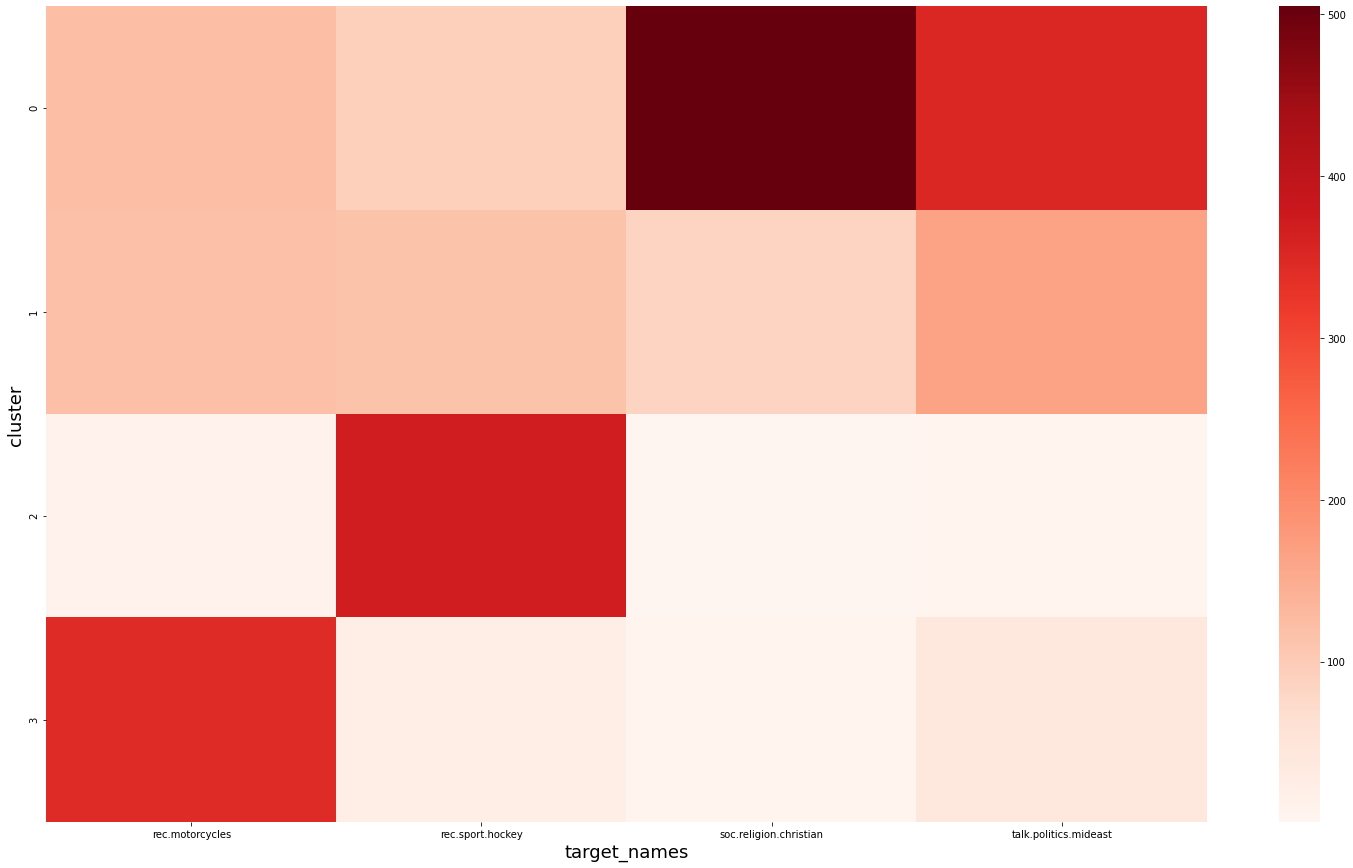

In [17]:
clusters = newsgroup.groupby(['cluster', 'target_names']).size()
fig, ax1 = plt.subplots(figsize = (26, 15))
heatmap(clusters.unstack(level = 'target_names'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

In [23]:
# assigning cluster to target
def label_race (row):
   if row['cluster'] == 0 :
      return 15
   if row['cluster'] == 1 :
      return 17
   if row['cluster'] == 2 :
      return 10
   if row['cluster'] == 3 :
      return 8
   return 'Other'


In [24]:
#add a column predto the data frame setting its values to the target you would expect
newsgroup['pred'] = newsgroup.apply(label_race, axis=1)
newsgroup

,content,target,target_names,preprocessed,cluster,pred
0,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,worth ducati gt line ducati gt model clock run...,3,8
1,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,articl apr samba oit unc edu scott mark launch...,1,17
2,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,articl apr atho rutger edu cleveland freenet e...,0,15
3,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,articl spam math adelaid edu jaskew spam math ...,1,17
4,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,articl netnew upenn edu kkeller mail sa upenn ...,1,17
...,...,...,...,...,...,...
2356,From: cbetz@radioman.cray.com (Charles Betz {...,10,rec.sport.hockey,read report possibl nhl move milwauke milwauke...,2,10
2357,From: 2120788@hydra.maths.unsw.EDU.AU ()\nSubj...,17,talk.politics.mideast,articl apr iastat edu tankut iastat edu sabri ...,1,17
2358,From: aa888@freenet.carleton.ca (Mark Baker)\n...,15,soc.religion.christian,previou articl phsd vaxc monash edu sai articl...,0,15
2359,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,apr yuma acn colost edu inin articl apr yuma a...,1,17


In [25]:
print(classification_report(newsgroup.pred, newsgroup.target))

              precision    recall  f1-score   support

           8       0.58      0.83      0.68       415
          10       0.62      0.96      0.75       386
          15       0.84      0.47      0.60      1072
          17       0.29      0.34      0.32       488

    accuracy                           0.59      2361
   macro avg       0.58      0.65      0.59      2361
weighted avg       0.65      0.59      0.58      2361



In [27]:
corpus_gen=[doc.split() for doc in newsgroup.preprocessed]
len(corpus_gen)

2361

In [28]:
from gensim.corpora import Dictionary
dictionary = Dictionary(corpus_gen)
dictionary.filter_extremes(no_below=118, no_above=0.95)

In [29]:
print(dictionary)

Dictionary(305 unique tokens: ['bike', 'bit', 'dod', 'hard', 'like']...)


In [30]:
corpus=[dictionary.doc2bow(doc) for doc in corpus_gen]

In [31]:
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, iterations=100, passes=10)

In [32]:
lda.show_topics()

[(0,
  '0.060*"edu" + 0.049*"write" + 0.039*"articl" + 0.031*"like" + 0.028*"com" + 0.024*"know" + 0.022*"apr" + 0.020*"time" + 0.019*"wai" + 0.018*"good"'),
 (1,
  '0.078*"team" + 0.054*"game" + 0.049*"hockei" + 0.041*"plai" + 0.039*"year" + 0.039*"new" + 0.038*"bike" + 0.027*"win" + 0.026*"player" + 0.025*"nhl"'),
 (2,
  '0.060*"god" + 0.030*"believ" + 0.029*"christian" + 0.028*"peopl" + 0.021*"reason" + 0.021*"thing" + 0.019*"jesu" + 0.018*"think" + 0.016*"read" + 0.015*"faith"'),
 (3,
  '0.045*"israel" + 0.034*"isra" + 0.029*"state" + 0.028*"peopl" + 0.027*"jew" + 0.024*"year" + 0.024*"kill" + 0.023*"armenian" + 0.023*"arab" + 0.022*"turkish"')]

In [35]:
topics=lda[corpus]
newsgroup['topics_lda']=[max(topics[i])[0] for i in range(len(topics))]
newsgroup

,content,target,target_names,preprocessed,cluster,pred,topics_lda
0,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,worth ducati gt line ducati gt model clock run...,3,8,3
1,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,articl apr samba oit unc edu scott mark launch...,1,17,3
2,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,articl apr atho rutger edu cleveland freenet e...,0,15,3
3,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,articl spam math adelaid edu jaskew spam math ...,1,17,3
4,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,articl netnew upenn edu kkeller mail sa upenn ...,1,17,1
...,...,...,...,...,...,...,...
2356,From: cbetz@radioman.cray.com (Charles Betz {...,10,rec.sport.hockey,read report possibl nhl move milwauke milwauke...,2,10,3
2357,From: 2120788@hydra.maths.unsw.EDU.AU ()\nSubj...,17,talk.politics.mideast,articl apr iastat edu tankut iastat edu sabri ...,1,17,3
2358,From: aa888@freenet.carleton.ca (Mark Baker)\n...,15,soc.religion.christian,previou articl phsd vaxc monash edu sai articl...,0,15,2
2359,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,apr yuma acn colost edu inin articl apr yuma a...,1,17,3


In [36]:
pyLDAvis.enable_notebook()
LDAvis_prepared = prepare(lda, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.333675  0.138340       1        1  39.078623
2     -0.040966 -0.160577       2        1  27.108609
3     -0.021417 -0.186916       3        1  20.587305
1     -0.271293  0.209154       4        1  13.225463, topic_info=       Term         Freq        Total Category  logprob  loglift
17      edu  2635.000000  2635.000000  Default  30.0000  30.0000
36      god  1833.000000  1833.000000  Default  29.0000  29.0000
232    team  1156.000000  1156.000000  Default  28.0000  28.0000
27    write  2135.000000  2135.000000  Default  27.0000  27.0000
71   israel  1038.000000  1038.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
99     john   123.915149   253.088033   Topic4  -4.7847   1.3089
3      hard   133.849011   279.682495   Topic4  -4.7076   1.2861
48    point   227.579365   651.789067   Topic4  -4.1768   0.9708
50     post   205.818501   658.347094   Topic4  -4.2773   0.8603
140   world   150.559727   531.078327   Topic4  -4.5899   0.7625

[198 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
63        1  0.998578  actual
141       2  0.995734  answer
12        1  0.999122     apr
64        3  0.998734    arab
185       2  0.038933    area
...     ...       ...     ...
140       4  0.284327   world
27        1  0.999397   write
279       2  0.995476   wrong
104       3  0.490765    year
104       4  0.508450    year

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])